# Distribution B - L-Infinity Fit from Samples

In [111]:
import DistBTrunc as dbt
import DistExampB as db

from math import ceil, floor, sqrt
from matplotlib import pyplot as plot
from numpy import array
from sympy import Symbol
from scipy.optimize import minimize

from LocMath import Sqr
from LocUtil import Grid1, MinMax, MinIndex, SetSeed, UnZip
from Map import LogRatio
from Sinc import FitLstSqr, Interp
from StopWatch import StopWatch

In [68]:
nSamp = 100

givenSeed = None
seedDig = 3

nPlot = 101
figSize = (9, 6.5)

dist = db.ExampB()

nLim = 20

In [26]:
seed = SetSeed(givenSeed, seedDig)
if givenSeed is None:
	print(f'seed = {seed}')

samp = sorted(tuple(dist.Sample() for _ in range(nSamp)))
quant = tuple((k + 0.5) / nSamp for k in range(nSamp))

seed = 821


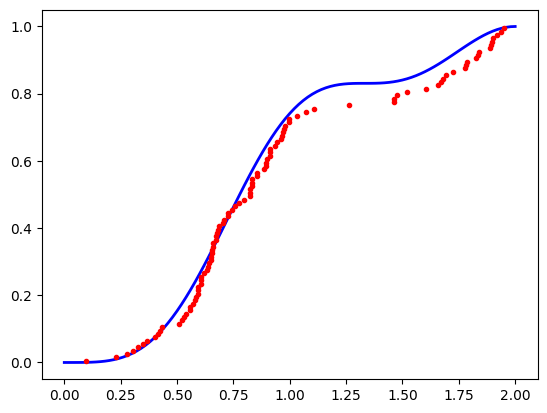

In [27]:
plot.plot(samp,quant, '.', c='red')

xGrid = Grid1(0,2,nPlot)
cdfX = tuple(dist.Cdf(x) for x in xGrid)
plot.plot(xGrid, cdfX, c="blue", lw=2, zorder=-1)

## Map to Z

In [28]:
xSym = Symbol('x')
zSym = Symbol('z')

map_ = LogRatio(xSym, zSym, (0, 2))

In [29]:
map_.forSym

log(x/(2 - x))

In [30]:
sampZ = tuple(map_.Forward(x) for x in samp)

In [31]:
zRange = MinMax(sampZ)
zRange

(-2.9922007136874536, 3.6719282042590167)

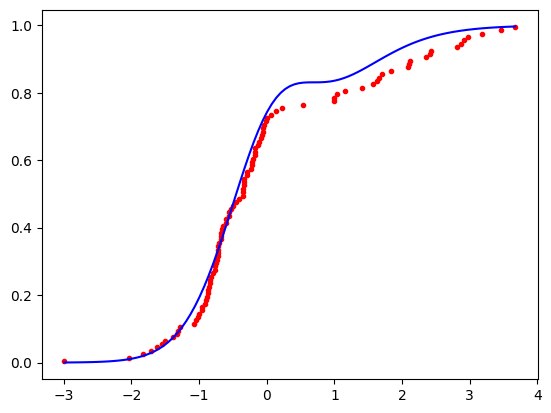

In [32]:
plot.plot(sampZ,quant, '.', c='red')

zGrid = Grid1(*zRange, nPlot)
nullGrid = [dist.Cdf(map_.Inverse(z)) for z in zGrid]
plot.plot(zGrid,nullGrid, c='blue')

## Residue

In [33]:
sampRes = tuple(q - dbt.NullZ(z) for (z,q) in zip(sampZ, quant))

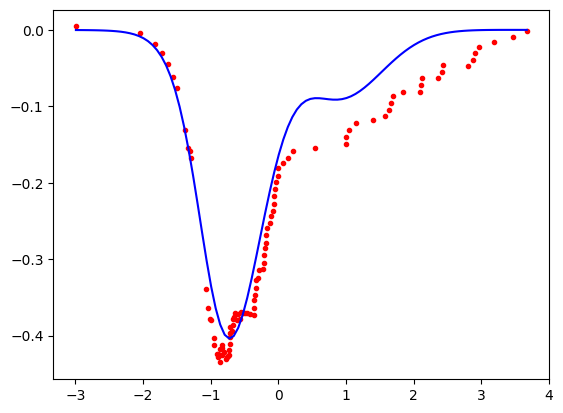

In [34]:
plot.plot(sampZ,sampRes, '.', c='red')

resGrid = tuple(dbt.ResZ(z) for z in zGrid)
plot.plot(zGrid,resGrid, c='blue')

## Sinc Fit

In [36]:
zLim = MinMax(sampZ)
zMin,zMax = zLim
zMin,zMax

(-2.9922007136874536, 3.6719282042590167)

In [37]:
zRange = zMax - zMin
zRange

6.664128917946471

In [38]:
hMin,hMax = 0.2,3

In [39]:
nMin = ceil(zRange / hMax) + 1
nMin

4

In [40]:
nMax = floor(zRange / hMin) + 1
nMax

34

In [103]:
nLim = 16

In [104]:
nL = tuple(range(nMin, min(nMax,nLim) + 1))
nL

(4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)

In [105]:
sampPoint = tuple(zip(sampZ, sampRes))

In [123]:
def FitLInf(samp, zRange,nSinc):
	sampZ, sampV = UnZip(samp)
	sincZ = Grid1(*zRange, nSinc)
	h = (zRange[1] - zRange[0]) / (nSinc - 1)
	
	def LInf(sincV):
		interpV = Interp(tuple(zip(sincZ,sincV)), sampZ)
		diff = tuple(sV - iV for (sV,iV) in zip(sampV, interpV))
		result = max(abs(d) for d in diff)
	
		return result

	temp = FitLstSqr(samp, zRange,nSinc)
	_,start = UnZip(temp[0])
	
	# start = tuple(0 for _ in range(nSinc))
	
	minResult = minimize(LInf, start)
	result = tuple(zip(sincZ,minResult.x))
	
	return result

In [124]:
timer = StopWatch(running=True)
fitTab = tuple((n, FitLInf(sampPoint, zLim,n)) for n in nL)
timer.Stop()

255.81992149999132

#### Show Fits

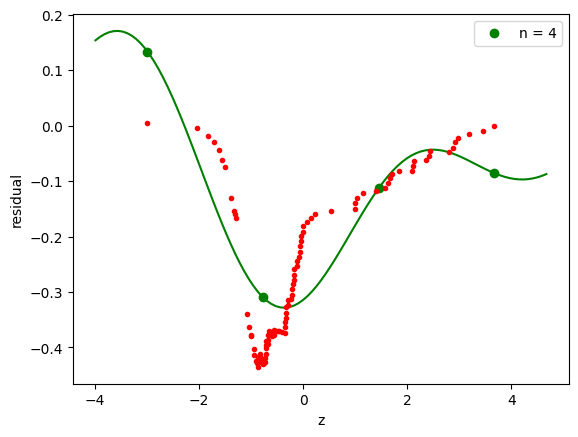

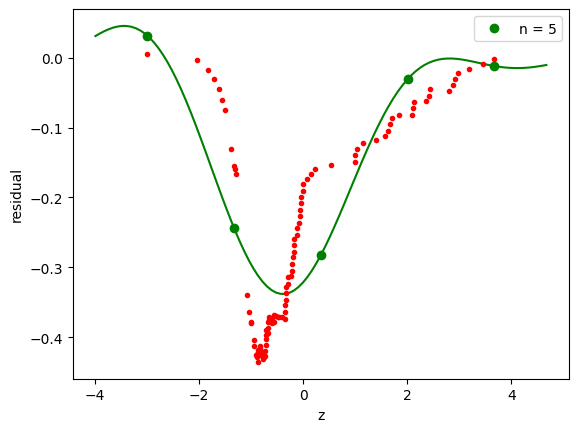

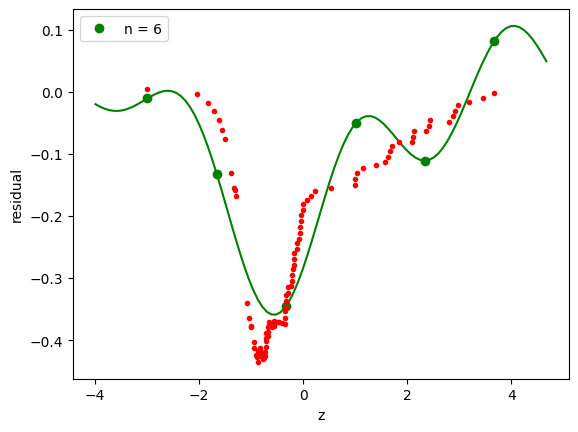

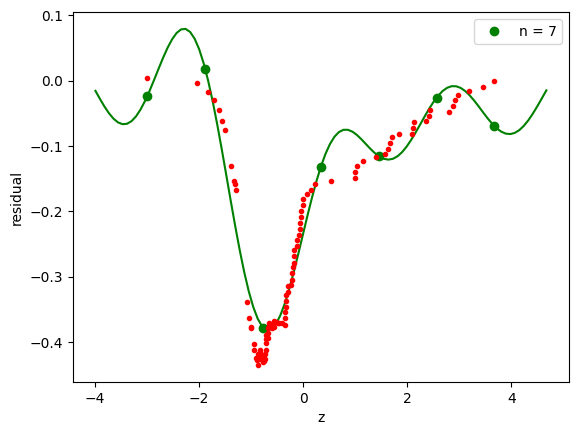

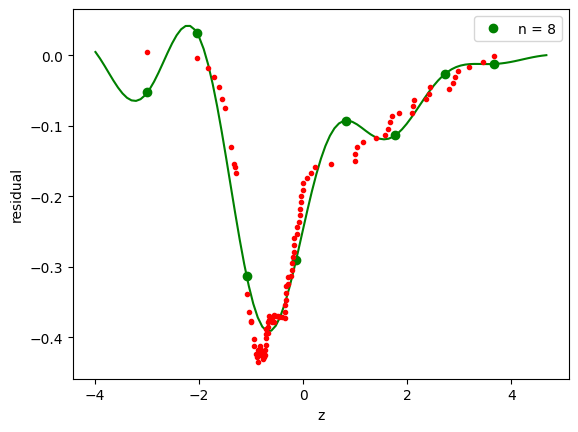

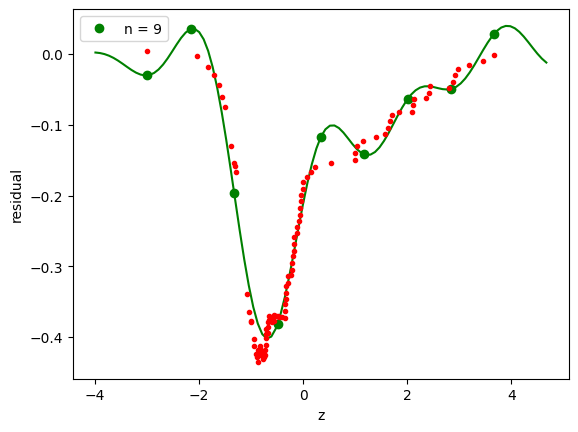

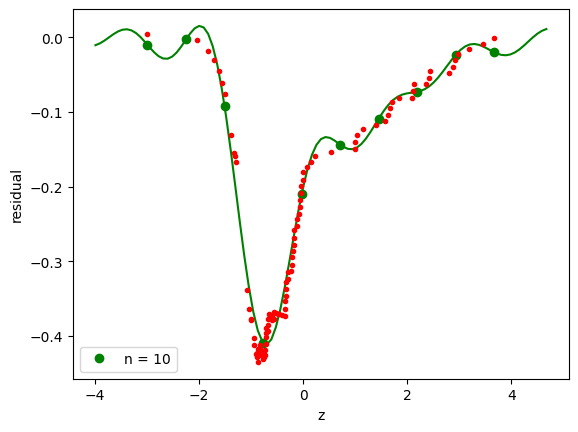

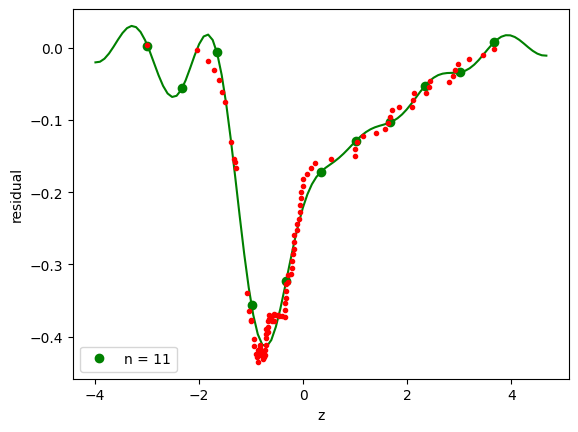

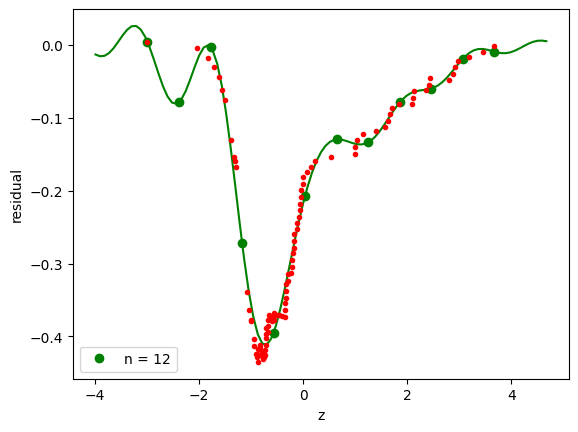

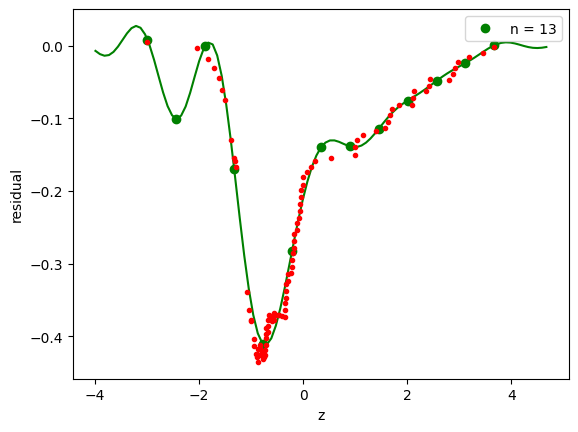

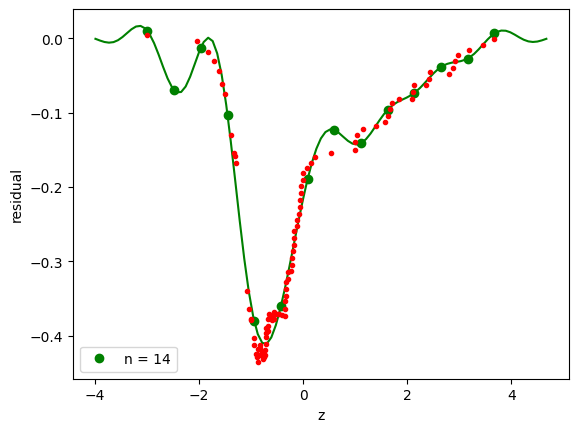

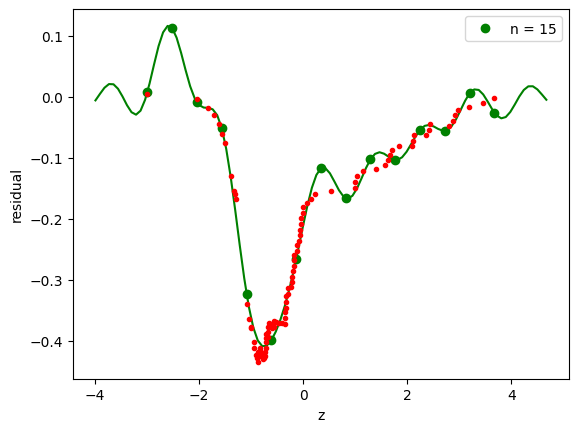

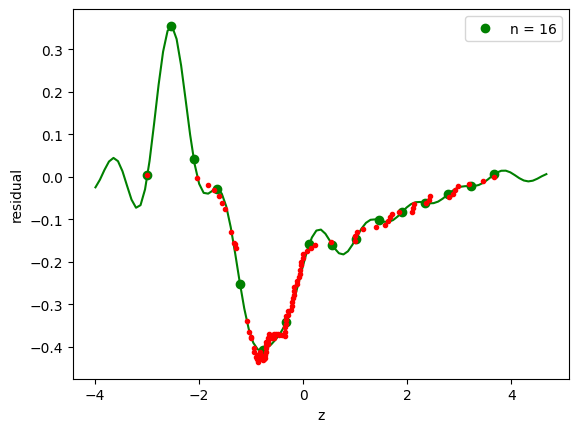

In [125]:
for (n,sincPoint) in fitTab:
	plot.plot(*UnZip(sincPoint), 'o', markersize=6, c='green', label=f'n = {n}')
		
	zGrid = Grid1(zMin - 1, zMax + 1, nPlot)
	interpV = Interp(sincPoint, zGrid)
	plot.plot(zGrid,interpV, c='green')	
	
	plot.plot(*UnZip(sampPoint), '.', c='red')
	
	plot.xlabel('z')
	plot.ylabel('residual')
	plot.legend()
	
	plot.show()

## Do L-Infinity of Least Squares Fit

In [126]:
def LInf(sincPoint, sampPoint):
	sampZ,sampV = UnZip(sampPoint)
	
	interpV = Interp(sincPoint, sampZ)
	diff = tuple(sV - iV for (sV,iV) in zip(sampV, interpV))
	result = max(abs(d) for d in diff)
	
	return result

Text(0, 0.5, 'L-Infinity')

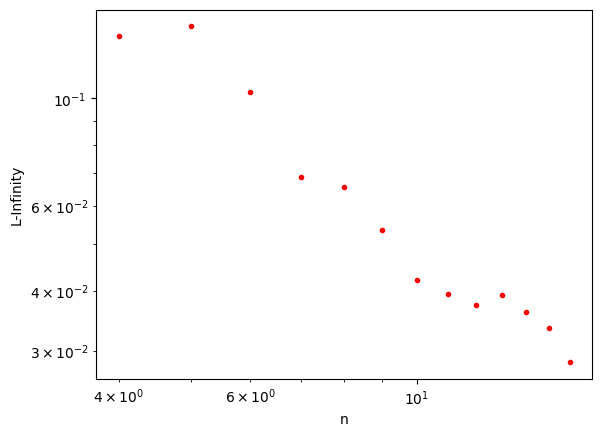

In [127]:
lInf = tuple(LInf(sincPoint, sampPoint) for (_,sincPoint) in fitTab)
plot.loglog(nL, lInf, '.', c='red')

plot.xlabel('n')
plot.ylabel('L-Infinity')

Suspect that the minimization is no converging

## Do RMS Deviation from True Residual

In [128]:
rms = tuple(
	sqrt(sum(Sqr(dbt.ResZ(z) - v) for (z,v) in sincPoint) / n) 
	for (n,sincPoint) in fitTab
)

Text(0, 0.5, 'RMS Error')

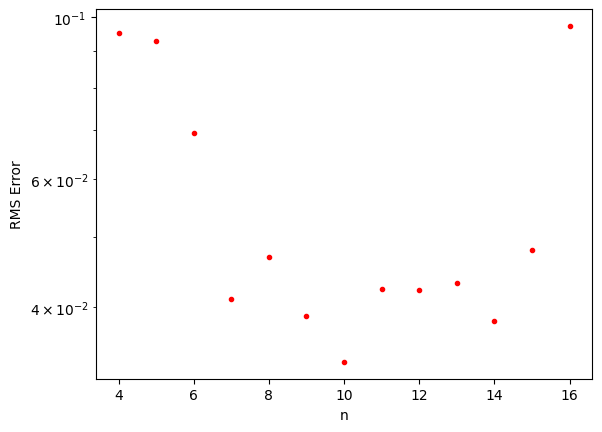

In [129]:
plot.semilogy(nL,rms, '.', c='red')

plot.xlabel('n')
plot.ylabel('RMS Error')

In [130]:
fitTab[MinIndex(rms)][0], min(rms)

(10, 0.03367725509742928)